# Tarea 1 Deep Learning

Francisco Rencoret (FranciscoRencoret1) - Raimundo Manterola (rmant)

### Kill previous instance and install dependencies

In [0]:
!ps ax | grep python

In [0]:
!kill -8 452

Instalamos las dependencias necesarias y vemos cuanta GPU tenemos disponible

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import cv2
import numpy as np
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0] # Only one GPU on Colab and isn’t guaranteed
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available),"IProcsize:"+ humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% |Total{3:.0f}MB".format(gpu.memoryFree,gpu.memoryUsed, gpu.memoryUtil*100,gpu.memoryTotal))
    
printm()
    

### Saving files from Google Colab

In [0]:
!pip install -U -q PyDrive

In [0]:
import tensorflow as tf
import timeit

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Importando Keras

In [13]:
#Definicion de librerias con la funciones que seran utilizadas por Keras.
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from keras import applications, optimizers
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
!mkdir checkpoints

Using TensorFlow backend.


# Parte 1 

## Descargamos el dataset que se utilizará

In [0]:
!wget https://www.dropbox.com/s/c0d7npcg1yysnux/MIT-10-Classes.zip?dl=0
!unzip -q MIT-10-Classes.zip?dl=0

## Definiendo Alexnet

In [3]:
#Definicion de contenedor y primera capa de AlexNet.
modelAlexNet = Sequential()
modelAlexNet.add(ZeroPadding2D((2,2), input_shape=(224, 224, 3)))
modelAlexNet.add(Convolution2D(96, (11,11), strides=(4,4), padding="valid"))
modelAlexNet.add(Activation(activation="relu"))
output_shape_first_layer = modelAlexNet.output_shape
print('Los mapas de activación de la capa 1 de convolción tienen tamaño: {}'.format(output_shape_first_layer))
modelAlexNet.add(BatchNormalization())
modelAlexNet.add(MaxPooling2D((3,3), strides=(2,2)))

Los mapas de activación de la capa 1 de convolción tienen tamaño: (None, 55, 55, 96)


In [4]:
#Definicion de la segunda capa de AlexNet.
modelAlexNet.add(ZeroPadding2D((2,2)))
modelAlexNet.add(Convolution2D(256, (5, 5), padding="valid"))
modelAlexNet.add(Activation(activation="relu"))
output_shape_second_layer = modelAlexNet.output_shape
print('Los mapas de activación de la capa 2 de convolción tienen tamaño: {}'.format(output_shape_second_layer))
modelAlexNet.add(BatchNormalization())
modelAlexNet.add(MaxPooling2D((3,3), strides=(2,2)))

Los mapas de activación de la capa 2 de convolción tienen tamaño: (None, 27, 27, 256)


## Actividad 1

Notamos que la primera capa de AlexNet es de tamaño (55, 55, 96). Como podemos ver, nuestra primera capa tiene las mismas dimensiones:

In [5]:
output_shape_first_layer

(None, 55, 55, 96)

La segunda capa de AlexNet es de tamanño (27, 27, 256). Nuestra segunda capa tiene las mismas dimensiones

In [6]:
output_shape_second_layer

(None, 27, 27, 256)

Ahora, vamos a mostrar un resumen de la red creada

In [7]:
modelAlexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
__________

Podemos notar que en la primera capa, teniamos filtros de tamaño 11 x 11 x 3 + 1 pesos (11 x 11 con profundidad 3 + el bias). Ahora, como la primera capa tiene 96 mapas de activacion, vamos a tener 96 de estos filtros, por lo que en la primera capa se tiene (11 x 11 x 3 + 1) x 96 = 34,944 pesos. Podemos ver que esto coincide con el valor de la segunda fila de la tabla.

La segunda capa tiene filtros de 5 x 5 x 96 + 1 (5 x 5 con profundidad 96 + un bias) y tenemos 256 mapas de activacion, por lo que en total la capa tiene (5 x 5 x 96 + 1) x 256 = 614,656. Esto coincide con el valor de la septima fila de la tabla.

Por otra parte, podemos notar que el batch normaliation en ambos casos calcula 4 parametros. Como la normalización consiste en:

$$\begin{equation}
\hat{a} =  \frac{x - \mu}{\sigma}
\end{equation}$$

y luego

$$\begin{equation}
\hat{x} =  \varphi \hat{a} + \beta
\end{equation}$$

la red debe calcular y almacenar $\mu$ y $\sigma$ (parametros no entrenables). Por otro lado, debe calcular y entrenar a $\varphi$ y $\beta$, por lo que por cada mapa de activacion almacena 4 pesos pero solo entrena 2. En total, primer batch tiene 96 x 4 = 384 pesos (192 entrenables) y el segundo 256 x 4 = 1024 (512 entrenables).

En resumen:
Pesos: 34,944 + 384 + 614,656 + 1024 = 651,008
Pesos entrenables: 34,944 + 192 + 614,656 + 512 = 650,304

## Actividad 2

In [8]:
#Definicion de la tercera capa de AlexNet
modelAlexNet.add(ZeroPadding2D((1,1)))
modelAlexNet.add(Convolution2D(384, (3, 3), strides=(1,1), padding="valid"))
modelAlexNet.add(Activation(activation="relu"))
output_shape_third_layer = modelAlexNet.output_shape
print('Los mapas de activación de la capa 3 de convolción tienen tamaño: {}'.format(output_shape_third_layer))

Los mapas de activación de la capa 3 de convolción tienen tamaño: (None, 13, 13, 384)


Verificamos que tenga las mismas dimensiones

In [9]:
output_shape_third_layer

(None, 13, 13, 384)

Volvemos a revisar el resumen de la red

In [10]:
modelAlexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
__________

## Actividad 3

In [11]:
#Definicion de la cuarta capa de AlexNet
modelAlexNet.add(ZeroPadding2D((1,1)))
modelAlexNet.add(Convolution2D(384, (3, 3), strides=(1,1), padding="valid"))
modelAlexNet.add(Activation(activation="relu"))
output_shape_fourth_layer = modelAlexNet.output_shape
print('Los mapas de activación de la capa 4 de convolción tienen tamaño: {}'.format(output_shape_fourth_layer))

Los mapas de activación de la capa 4 de convolción tienen tamaño: (None, 13, 13, 384)


In [12]:
#Definicion de la quinta capa de AlexNet
modelAlexNet.add(ZeroPadding2D((1,1)))
modelAlexNet.add(Convolution2D(256, (3, 3), strides=(1,1), padding="valid"))
modelAlexNet.add(Activation(activation="relu"))
output_shape_fifth_layer = modelAlexNet.output_shape
print('Los mapas de activación de la capa 5 de convolción tienen tamaño: {}'.format(output_shape_fifth_layer))
modelAlexNet.add(MaxPooling2D((3,3), strides=(2,2)))

Los mapas de activación de la capa 5 de convolción tienen tamaño: (None, 13, 13, 256)


Nuevamente verificamos que las dimensiones son correctas. Al igual que la capa 3, las dimensiones de la capa 4 son (13, 13, 384). La quinta capa tiene dimensiones (13, 13, 256). Viendo las dimensiones de AlexNet, notamos que coinciden. Ahora, revisemos el resumen del modelo para ver la cantidad de parametros:

In [13]:
modelAlexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
__________

Podemos notar que la cuarta capa tiene más parámetros que la tercera capa, porque a pesar de tener la misma estrucutra (filtros de igual tamaño pero distinta profundidad, mapas de activación de igual tamaño), vemos que su input es distinto. La tercera recibe un input de (13, 13, 256), mientras que la cuarta recibe un input de (13, 13, 384). Por lo tanto, los filtros van a tener profundidades distintas lo que se traduce en una distinta cantidad de parametros.

Por otra parte, notamos que la quinta capa recibe el mismo input que la cuarta, pero como la quinta tiene menos mapas de activación, la cantidad de parametros que debe manejar es menor. 

Por último, notamos que como no incluimos normalización de los batches, la cantidad de parametros no entrenables no cambia.

## Actividad 4

Actualmente tenemos la matriz como un tensor de 3D. Como ahora tenemos que agregar las capas densas para clasificar, debemos tener la matríz como un vector de una dimensión, para luego poder hacer correctamente las conexiones con la capa densa. Para eso, usamos el comando Flatten, que lo que hace es poner en un solo vector todos los datos del tensor 3D, por lo que tendria dimensiones 6 x 6 x 256 = 9216. Agregamos la capa:

In [0]:
modelAlexNet.add(Flatten())

In [15]:
modelAlexNet.output_shape

(None, 9216)

Notamos que esto efectivamente hizo lo que necesitabamos, porque ahora el modelo tiene dimensiones (1, 9216).

## Actividad 5

In [0]:
#Definicion de la capa 6 de AlexNet
modelAlexNet.add(Dense(4096, input_shape=(9216,), activation='relu', kernel_initializer='glorot_uniform', use_bias=True))
modelAlexNet.add(Dropout(0.5))
output_shape_sixth_layer = modelAlexNet.output_shape

Esta capa deberia tener dimensiones de (1, 4092), por lo que verificamos con modelAlexNet:

In [17]:
output_shape_sixth_layer

(None, 4096)

Podemos notar que tiene las dimensiones correctas. Ahora, analizemos la cantidad de parametros que lleva la red por el momento:

In [18]:
modelAlexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
__________

Esta ultima capa esta compuesta por 4096 neuronas y recibe como input un vector de (1, 9216). Al ser una capa Dense (fully connected), sabemos que todas las entradas se conectan con todas la neuronas de la capa, por lo que la cantidad de parametros de la capa sería 4096 * 9216 = 37,752,832. Este es un numero muy grande, son 37 millones de parametros que provinen solamente de la primera capa del clasificador. 

Esto nos hace notar lo 'eficientes' en cuanto a memoria y a entrenamiento que son las CNN. Si sumamos las 5 capas de convolucion obtenemos 3,748,608 parametros, mientras que solo esta primera capa de la FC, tiene 37,752,832 parametros (debe entrenar y almacenar aprox 10 veces más).

En total tenemos 41,501,440 parametros donde solo 704 no son entrenables. Esta cantidad no ha cambiado porque nuevamente no hemos agregado un batch normalization.

## Actividad 6

In [0]:
#Definición de la capa 7 de AlexNet
modelAlexNet.add(Dense(4096, activation='relu', kernel_initializer='glorot_uniform', use_bias=True))
modelAlexNet.add(Dropout(0.5))
output_shape_seventh_layer = modelAlexNet.output_shape

In [0]:
#Definición de la capa 8 de AlexNet
modelAlexNet.add(Dense(10, activation='softmax', kernel_initializer='glorot_uniform', use_bias=True))
output_shape_eighths_layer = modelAlexNet.output_shape

In [21]:
modelAlexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
__________

Cantidad de filtros: 1,376
Cantidad total de parametros: 62,379,752
Cantidad de parámetros entrenables: 62,379,048
Cantidad de parámetros no entrenables: 704

Resumiendo las capas:
    1. Filtros: 96
       Cantidad de neuronas por filtro: 55 x 55 = 3,025
       Cantidad total de neuronas de capa: 290,400
       Parámetros: 34,944 (filtros) + 384 (batch normalization)
       
    2. Filtros: 256
       Cantidad de neuronas por filtro: 27 x 27 = 729
       Cantidad total de neuronas de capa: 186,624
       Parámetros: 614,656 (filtros) + 1024 (batch normalization)
       
    3. Filtros: 384
       Cantidad de neuronas por filtro: 13 x 13 = 169
       Cantidad total de neuronas de capa: 64,896
       Parámetros: 885,120 (filtros)
       
    4. Filtros: 384
       Cantidad de neuronas por filtro: 13 x 13 = 169
       Cantidad total de neuronas de capa: 64,896
       Parámetros: 1,327,488 (filtros)
       
    5. Filtros: 256
       Cantidad de neuronas por filtro: 13 x 13 = 169
       Cantidad total de neuronas de capa: 43,264
       Parámetros: 884,992 (filtros)
       
    6. Cantidad total de neuronas de capa: 4,096
       Parámetros: 37,752,832
    
    7. Cantidad total de neuronas de capa: 4,096 
       Parámetros: 16,781,312
    
    8. Cantidad total de neuronas de capa: 1,000
       Parámetros: 4,097,000
 
La capa 3 y 4 llevan 384 filtros, siendo las capas con mayor cantidad de filtros. Por otro lado, la primera capa densa es la que tiene más parámetros, 37,752,832.
 
Como mencioné anteoriormente, notamos que las capas de convolución (1 - 5) no aportan tantos parámetros a la red. Cada las neuronas que componen un filtro comparten los pesos, por lo que se reduce mucho la cantidad de pesos por capa. Esto es principalmente para que todas las neuronas de ese filtro se activen cuando encuentren el mismo patrón, es decir, cuando el producto punto entre el input y los pesos (iguales para todos) sea alto. De esta manera, cada mapa de activación es capas de detectar un patrón sobre su input. Luego, la siguiente capa de convolución va a encontrar patrones sobre estos patrones ya encontrados por cada filtro, construyendo sobre estos y encontrando objetos de mayer abstracción. En total, estas capas proveen 3,748,608 pesos.

Luego, agregamos esta otras 3 capas de fully-connected donde se conectan todas las neuronas con todas. Esto implica el entrenamiento y almacenamiento de muchos pesos. Sumando las 3 capas densas obtenemos 58,631,144 pesos. Obviamente, esta suma es muy alta por lo que requiere alto entrenamiento y varios datos para poder obtener resultados relativamente buenos. 

La arquitectura de las capas de convolución es óptima porque necesita pocos parametros y aún asī es capas de detectar figuras de alto nivel de complejidad; las cuales luego serán clasificadas como: caras, objetos, humanos etc... Las 3 capas densas de clasificación aportan muchos parámetros, por lo que es costoso entrenarla. Creo que una buena práctica sería probar con clasificadores más simples (SVM o KNN) primero. Si se obtienen buenos resultados con esos no es necesario implementar estas 3 capas, pero puede darse el caso de que la cantidad de features sea demasiado alta comparado con la cantidad de datos causando que estos clasificadores no clasifiquen bien. En ese caso necesitaríamos estas capas densas que se comportan bien independiente de la dimensionalidad de los datos.


## Actividad 7

Comenzamos cargando la data del directorio provisto

In [0]:
import scipy.io as sio
import os
from sklearn.metrics import accuracy_score, confusion_matrix

In [0]:
def load_mat_set(directory):
    #Load the clases
    cls = os.listdir(directory)
    #Create empty arrays
    X = []
    Y = []
    #Load the set
    for cl in cls:
        for mat in os.listdir(directory + '/' + cl):
            X.append(sio.loadmat(directory + '/' + cl + '/' + mat)['stored'][0])
            Y.append(cl)
        
    return X, Y

X_train , Y_train = load_mat_set('./MIT-10-Classes/Feats/TrainSet')
X_test, Y_test = load_mat_set('./MIT-10-Classes/Feats/TestSet')

In [24]:
ls './MIT-10-Classes/Imgs/TrainSetImgs'

bowling/   concert_hall/  gameroom/    laundromat/  studiomusic/
cloister/  florist/       greenhouse/  pantry/      winecellar/


In [25]:
#Print the dimensions of dataset
print('X_train : {}'.format(len((X_train))))
print('Y_train : {}'.format(len((Y_train))))
print('X_test : {}'.format(len((X_test))))
print('Y_test : {}'.format(len((Y_test))))

X_train : 799
Y_train : 799
X_test : 201
Y_test : 201


Para esta activdad vamos a entrenar un SVM. Para el SVM, vamos a usar la libreria skilearn que provee un SVM ya implementado

In [0]:
from sklearn import svm

In [0]:
#Instance a SVC model from sklearn. LinearSVC is a type of SVM for multiclass clasification.
#LinearSVC trains n_classes models using one-vs-rest clasifiers (each model clasifies one class). 
#For classifying, every classifier is tested and the result with the higher probability is chosen.
clf = svm.LinearSVC()

In [28]:
clf.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Primero, vamos a probar el modelo sobre el set de entrenamiento

In [29]:
Y_train_pred = clf.predict(X_train)
accuracy_score(Y_train, Y_train_pred)

1.0

El clasificador tiene 100% efectividad sobre el set de entrenamiento. Esto podría indicar que el modelo calló en over-fitting, como mencionamos anteriormente, esto podría ocurrir porque la dimensioón de los datos - 4096 - es mucho mayor que la cantidad de datos - 799 -. Para verificar esto, veamos el rendimiento sobre el set de test

In [0]:
Y_pred = clf.predict(X_test)

In [31]:
accuracy_score(Y_test, Y_pred)

0.9701492537313433

Podemos notar que tiene una accuracy score de 97%, lo que es bastante bueno. Como se parecen ambos rendimientos, podemos descartar el hecho de que el modelo se over-fittio porque efectivamente pudo clasificar muy bien el set de test. Adicionalmente mostramos la matriz de confusión

In [32]:
confusion_matrix(Y_test, Y_pred)

array([[20,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 19,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 19,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0, 20,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 19,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 19,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 21]])

## Actividad 8

Comenzamos compilando el modelo creado. Vamos a usar la función de perdida categorical_crossentropy que nos permite clasificar multiples clases . Vamos a usar el optimizador adam porque hemos visto en otras CNN que funciona muy bien.

La estructura de AlexNet que haciamos creado anteriormente realmente no nos funciona para este set de datos. Nosotros habiamos creado una capa densa al final que tenia 1000 neuronas, es decir, que clasificaba 1000 categorias. El dataset MIT-10-Classes contiene solo 10 clases, por lo que debemos remover esa ultima capa y volver a agregar una densa de solo 10 neuronas:

In [33]:
modelAlexNet.layers.pop()
modelAlexNet.add(Dense(10, activation='softmax'))
modelAlexNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
__________

In [0]:
modelAlexNet.compile(optimizer=optimizers.Adam(lr=5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
import numpy as np
import cv2
import os

In [0]:
def load_set(directory):
    #Load the clases
    cls = os.listdir(directory)
    #Create empty arrays
    X = []
    Y = []
    #Load the set
    for cl in cls:
        for img in os.listdir(directory + '/' + cl):
            img_arr = img_to_array(load_img(directory + '/' + cl + '/' + img))
            resized = cv2.resize(img_arr, (224, 224))
            X.append(resized)
            Y.append(cl)
    return np.array(X), np.array(Y)

In [0]:
X_train, Y_train_string = load_set('./MIT-10-Classes/Imgs/TrainSetImgs')
X_test, Y_test_string = load_set('./MIT-10-Classes/Imgs/TestSetImgs')

In [39]:
print('X train set has {} elements'.format(X_train.shape[0]))
print('Y train set has {} elements'.format(Y_train_string.shape[0]))
print('X test set has {} elements'.format(X_test.shape[0]))
print('Y test set has {} elements'.format(Y_test_string.shape[0]))

X train set has 799 elements
Y train set has 799 elements
X test set has 201 elements
Y test set has 201 elements


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
def one_hot_encoder(string_set):
  # Convert train string classes to vector of dim (1,N). Vector has a 1 on the
  # corresponding class and 0 on the rest.
  encoder_train = LabelEncoder()
  encoder_train.fit(string_set)
  encoded_Y = encoder_train.transform(string_set)
  Y_train = to_categorical(encoded_Y)
  return Y_train

In [0]:
Y_train = one_hot_encoder(Y_train_string)
Y_test = one_hot_encoder(Y_test_string)

In [0]:
checkpoints = ModelCheckpoint(filepath='checkpoints/AlexNet.hdf5', verbose=1, save_best_only=True)
history = History()

Creamos estos dos callbacks para que nos ayuden a ver el desarollo del entrenamiento de manera eficiente.

Con el ModelCheckpoint vamos almacenando la mejor versión del modelo al final de cada época (sobre escribe si el modelo actual es mejor que el modelo almacenado). 

Con el History almacenamos el información asociada al rendimiento del modelo, como la evolución de el acuraccy y la val_loss. 


In [51]:
modelAlexNet.fit(X_train, Y_train, 
          batch_size = 32,
          epochs=50,
          verbose=1,
          callbacks = [checkpoints, history],
          validation_data = (X_test, Y_test))

Train on 799 samples, validate on 201 samples
Epoch 1/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3329 - acc: 0.1001 - val_loss: 2.3247 - val_acc: 0.0995

Epoch 00001: val_loss improved from inf to 2.32471, saving model to checkpoints/AlexNet.hdf5
Epoch 2/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3307 - acc: 0.1001 - val_loss: 2.3226 - val_acc: 0.0995

Epoch 00002: val_loss improved from 2.32471 to 2.32264, saving model to checkpoints/AlexNet.hdf5
Epoch 3/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3284 - acc: 0.1001 - val_loss: 2.3209 - val_acc: 0.0995

Epoch 00003: val_loss improved from 2.32264 to 2.32093, saving model to checkpoints/AlexNet.hdf5
Epoch 4/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3264 - acc: 0.1001 - val_loss: 2.3192 - val_acc: 0.0995

Epoch 00004: val_loss improved from 2.32093 to 2.31924, saving model to checkpoints/AlexNet.hdf5
Epoch 5/50
799/799 [==================

799/799 [==============================] - 5s 6ms/step - loss: 2.3228 - acc: 0.1001 - val_loss: 2.3164 - val_acc: 0.0995

Epoch 00006: val_loss improved from 2.31773 to 2.31636, saving model to checkpoints/AlexNet.hdf5
Epoch 7/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3215 - acc: 0.1001 - val_loss: 2.3147 - val_acc: 0.0995

Epoch 00007: val_loss improved from 2.31636 to 2.31475, saving model to checkpoints/AlexNet.hdf5
Epoch 8/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3196 - acc: 0.1001 - val_loss: 2.3138 - val_acc: 0.0995

Epoch 00008: val_loss improved from 2.31475 to 2.31377, saving model to checkpoints/AlexNet.hdf5
Epoch 9/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3183 - acc: 0.1001 - val_loss: 2.3126 - val_acc: 0.0995

Epoch 00009: val_loss improved from 2.31377 to 2.31265, saving model to checkpoints/AlexNet.hdf5
Epoch 10/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3170 - acc: 0.

799/799 [==============================] - 5s 6ms/step - loss: 2.3159 - acc: 0.1001 - val_loss: 2.3107 - val_acc: 0.0995

Epoch 00011: val_loss improved from 2.31169 to 2.31069, saving model to checkpoints/AlexNet.hdf5
Epoch 12/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3148 - acc: 0.1001 - val_loss: 2.3100 - val_acc: 0.0995

Epoch 00012: val_loss improved from 2.31069 to 2.30998, saving model to checkpoints/AlexNet.hdf5
Epoch 13/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3137 - acc: 0.1001 - val_loss: 2.3093 - val_acc: 0.0995

Epoch 00013: val_loss improved from 2.30998 to 2.30929, saving model to checkpoints/AlexNet.hdf5
Epoch 14/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3129 - acc: 0.1001 - val_loss: 2.3085 - val_acc: 0.0995

Epoch 00014: val_loss improved from 2.30929 to 2.30852, saving model to checkpoints/AlexNet.hdf5
Epoch 15/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3120 - acc:

799/799 [==============================] - 5s 6ms/step - loss: 2.3112 - acc: 0.1001 - val_loss: 2.3073 - val_acc: 0.0995

Epoch 00016: val_loss improved from 2.30787 to 2.30732, saving model to checkpoints/AlexNet.hdf5
Epoch 17/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3105 - acc: 0.1001 - val_loss: 2.3068 - val_acc: 0.0995

Epoch 00017: val_loss improved from 2.30732 to 2.30680, saving model to checkpoints/AlexNet.hdf5
Epoch 18/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3099 - acc: 0.1001 - val_loss: 2.3063 - val_acc: 0.0995

Epoch 00018: val_loss improved from 2.30680 to 2.30633, saving model to checkpoints/AlexNet.hdf5
Epoch 19/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3092 - acc: 0.1001 - val_loss: 2.3059 - val_acc: 0.0995

Epoch 00019: val_loss improved from 2.30633 to 2.30589, saving model to checkpoints/AlexNet.hdf5
Epoch 20/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3087 - acc:

799/799 [==============================] - 5s 6ms/step - loss: 2.3082 - acc: 0.1001 - val_loss: 2.3051 - val_acc: 0.0995

Epoch 00021: val_loss improved from 2.30555 to 2.30514, saving model to checkpoints/AlexNet.hdf5
Epoch 22/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3078 - acc: 0.1001 - val_loss: 2.3049 - val_acc: 0.0995

Epoch 00022: val_loss improved from 2.30514 to 2.30490, saving model to checkpoints/AlexNet.hdf5
Epoch 23/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3074 - acc: 0.1001 - val_loss: 2.3046 - val_acc: 0.0995

Epoch 00023: val_loss improved from 2.30490 to 2.30455, saving model to checkpoints/AlexNet.hdf5
Epoch 24/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3068 - acc: 0.1001 - val_loss: 2.3044 - val_acc: 0.0995

Epoch 00024: val_loss improved from 2.30455 to 2.30435, saving model to checkpoints/AlexNet.hdf5
Epoch 25/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3065 - acc:

799/799 [==============================] - 5s 6ms/step - loss: 2.3062 - acc: 0.1001 - val_loss: 2.3039 - val_acc: 0.0995

Epoch 00026: val_loss improved from 2.30409 to 2.30390, saving model to checkpoints/AlexNet.hdf5
Epoch 27/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3059 - acc: 0.1001 - val_loss: 2.3038 - val_acc: 0.0995

Epoch 00027: val_loss improved from 2.30390 to 2.30376, saving model to checkpoints/AlexNet.hdf5
Epoch 28/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3057 - acc: 0.1001 - val_loss: 2.3035 - val_acc: 0.0995

Epoch 00028: val_loss improved from 2.30376 to 2.30351, saving model to checkpoints/AlexNet.hdf5
Epoch 29/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3054 - acc: 0.1001 - val_loss: 2.3034 - val_acc: 0.0995

Epoch 00029: val_loss improved from 2.30351 to 2.30342, saving model to checkpoints/AlexNet.hdf5
Epoch 30/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3051 - acc:

799/799 [==============================] - 5s 6ms/step - loss: 2.3049 - acc: 0.1001 - val_loss: 2.3032 - val_acc: 0.0995

Epoch 00031: val_loss improved from 2.30334 to 2.30321, saving model to checkpoints/AlexNet.hdf5
Epoch 32/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3047 - acc: 0.1001 - val_loss: 2.3031 - val_acc: 0.0995

Epoch 00032: val_loss improved from 2.30321 to 2.30308, saving model to checkpoints/AlexNet.hdf5
Epoch 33/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3045 - acc: 0.0851 - val_loss: 2.3030 - val_acc: 0.0995

Epoch 00033: val_loss improved from 2.30308 to 2.30301, saving model to checkpoints/AlexNet.hdf5
Epoch 34/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3044 - acc: 0.0939 - val_loss: 2.3029 - val_acc: 0.0995

Epoch 00034: val_loss improved from 2.30301 to 2.30295, saving model to checkpoints/AlexNet.hdf5
Epoch 35/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3043 - acc:

799/799 [==============================] - 5s 6ms/step - loss: 2.3041 - acc: 0.1001 - val_loss: 2.3028 - val_acc: 0.0995

Epoch 00036: val_loss improved from 2.30292 to 2.30284, saving model to checkpoints/AlexNet.hdf5
Epoch 37/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3041 - acc: 0.1001 - val_loss: 2.3028 - val_acc: 0.0995

Epoch 00037: val_loss improved from 2.30284 to 2.30279, saving model to checkpoints/AlexNet.hdf5
Epoch 38/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3039 - acc: 0.1001 - val_loss: 2.3027 - val_acc: 0.0995

Epoch 00038: val_loss improved from 2.30279 to 2.30271, saving model to checkpoints/AlexNet.hdf5
Epoch 39/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3037 - acc: 0.0864 - val_loss: 2.3027 - val_acc: 0.0995

Epoch 00039: val_loss improved from 2.30271 to 2.30269, saving model to checkpoints/AlexNet.hdf5
Epoch 40/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3036 - acc:

799/799 [==============================] - 5s 6ms/step - loss: 2.3035 - acc: 0.0876 - val_loss: 2.3027 - val_acc: 0.0995

Epoch 00041: val_loss did not improve from 2.30266
Epoch 42/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3035 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00042: val_loss improved from 2.30266 to 2.30263, saving model to checkpoints/AlexNet.hdf5
Epoch 43/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3034 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00043: val_loss improved from 2.30263 to 2.30261, saving model to checkpoints/AlexNet.hdf5
Epoch 44/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3033 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00044: val_loss did not improve from 2.30261
Epoch 45/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3033 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00045: val_loss did not improve from 2.3

799/799 [==============================] - 5s 6ms/step - loss: 2.3032 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00047: val_loss improved from 2.30261 to 2.30259, saving model to checkpoints/AlexNet.hdf5
Epoch 48/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3031 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00048: val_loss did not improve from 2.30259
Epoch 49/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3031 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00049: val_loss did not improve from 2.30259
Epoch 50/50
799/799 [==============================] - 5s 6ms/step - loss: 2.3031 - acc: 0.0926 - val_loss: 2.3026 - val_acc: 0.0995

Epoch 00050: val_loss did not improve from 2.30259


Como no tenemos set de validación, lo que hicimos fue usar el set de test como validación. Entendemos que hacer esto podría crear un bias sobre el set de test porque lo estamos 'usando' para el entrenamiento, pero como no incluimos EarlyStopping u otro callback que tomara decisiones sobre el rendimiento y loss sobre el set de validación, notamos que no afecta en nada solamente nos ayuda a ver el rendimiento del modelo sobre el set de test. Es decir, está ahí con un proposito simplemente analítico y no cumple niuna función para el entrenamiento, manteniendo el set sin bias.

In [65]:
print("Saving Model")
modelAlexNet.save('modelAlexNet.h5')

Saving Model


Evaluamos nuestro modelo

In [52]:
metrics = modelAlexNet.evaluate(X_test, Y_test)
metrics

201/201 [==============================] - 0s 2ms/step


[2.302625533953235, 0.09950248756218906]

In [68]:
#Revisamos la estratificación de los datos
for cl in os.listdir('MIT-10-Classes/Imgs/TrainSetImgs/'):
  print('La clase {} tiene {} datos de train'.format(cl, len(os.listdir('MIT-10-Classes/Imgs/TrainSetImgs/'+cl))))

La clase bowling tiene 80 datos de train
La clase studiomusic tiene 81 datos de train
La clase concert_hall tiene 80 datos de train
La clase laundromat tiene 78 datos de train
La clase winecellar tiene 79 datos de train
La clase pantry tiene 80 datos de train
La clase gameroom tiene 80 datos de train
La clase florist tiene 81 datos de train
La clase cloister tiene 80 datos de train
La clase greenhouse tiene 80 datos de train


Podemos ver que obtuvimos una pérdida de 2.3026 y una acuraccy de 9.95%. A pesar de que lo entrenamos con 50 épocas, el modelo no aprendió nada porque los resultados obtenidos se asimilan a una elección uniforme sobre 10 clases (9.95% $\approx$ 10%). Es decir, el modelo predice igual a que sí estuviera predijiendo random sobre las clases.

Este rendimiento es de esperarse porque AlexNet es una red profunda que con solamente 800 datos simplemente obtiene demasiado bias y no logra aprender nada sobre ellos. De hecho, podemos notar que los datos están estratificados por lo que para cada clase hay solamente 80 datos, lo que es muy poco para que la red pueda aprender sobre ella. ImageNet (set con el que fue entrenado AlexNet) tiene 15 millones de imágenes y definitivamente 800 << 15.000.000

Para mejorar este rendimiento definitivamente deberiamos agrandar el set de train o intentar con otro optimizador en caso de que Adam no se este comportando bien. 

In [0]:
import matplotlib.pyplot as plt

def plot_acc_and_loss(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


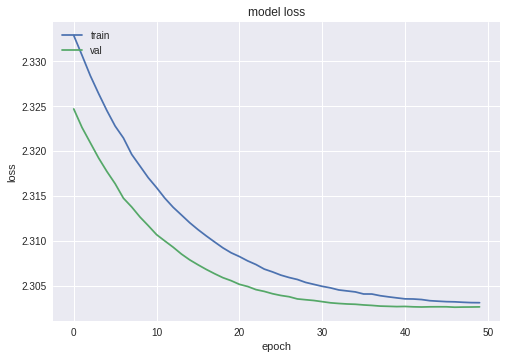

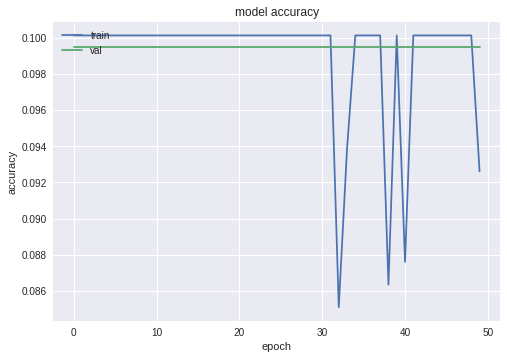

In [75]:
plot_acc_and_loss(history)

Podemos notar que la pérdida sobre el train y val efectivamente bajó con las épocas, pero si nos fijamos porcentualmente no bajo mucho. Comenzó con una pérdida de 2.3247 y hacía las últimas épocas se estabilizó en 2.305, es decir disminuyó solamente 1%. Esto claramente nos indica que el entrenamiento no fue capaz de mejorar casi nada la pérdida inicial , es decir, no aprendió casi nada.

Esto hace sentido mirando la gráfica del accuracy. Para el set de train, la accuracy se mantuvo en uniforme (10%) y en ciertas épocas bajo casi a 8%. La red no fue capaz de aprender nada sobre el set de train, por lo que siguiendo la teoría de las probabilidades, debería tener como máximo 10% de rendimiento. Lo mismo ocurre con el rendimiento sobre el set de val, donde nunca supera el 10%.

# Parte 2: Reconocimiento de Visual

## Actividad 9

In [78]:
#Vamos a hacer un summary de ambas para ver las principales diferencias:
vgg16 = applications.VGG16(weights = None )
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [79]:
resnet50 = applications.resnet50.ResNet50(weights=None)
resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Cuadro comparativo de VGG16 y ResNet50: 

<table>
  <tr>
    <td></td>
    <td>Total Parámetros</td>
    <td>Parámetros no entrenables</td>
    <td>Capas convolucionales</td>
    <td>Capas densas</td>
    <td>Top-1 Imagenet</td>
    <td>Top-5 Imagenet</td>
  </tr>
  <tr>
    <td>VGG16</td>
    <td>138,357,544</td>
    <td>0</td>
    <td>13</td>
    <td>3</td>
    <td>27.00</td>
    <td>8.80</td>
  </tr>
  <tr>
    <td>ResNet50</td>
    <td>25,636,712</td>
    <td>53,120</td>
    <td>53</td>
    <td>1</td>
    <td>24.01</td>
    <td>7.02</td>
  </tr>
</table>

###Parámetros:

La VGG16 tiene 5 veces más la cantidad de parámetros que tiene ResNet50. Análizando las estrucutas, notamos que la VGG16 es mucho menos profunda que ResNet50, por lo que esa gran cantidad de parámetros viene dado por las últimas 3 capas densas. Esto definitivamente es un problema de VGG16 poruqe entrenar 138 millones de parámetros es muy costoso computacionalmente, pero si cambiaramos el clasificador por uno que requiera menos pesos ahorraríamos éste problema. Por otra parte, podemos ver que todos los pesos de VGG16 son entrenables mientras que ResNet50 tiene 53.120 pesos que no se entrenan. Esto viene de Batch Normalization que usa ResNet50, mientras que VGG16 no lo hace.

###Capas Convolucionales:

Notamos que VGG16 tiene solamente 13 capas de convolución mientras que ResNet50 tiene 53. Aquí hay una notoría diferencia de profundidad. Como VGG16 solamente tiene 13 capas de convolución, no tienen que usar tantas prácticas para reducir el overfitting (solo usa MaxPooling), mientras que ResNet50 usa 53 capas por lo que si debe aplicar estas. Podemos ver que ResNet50 aplica MaxPooling y mucho BatchNormalization para reducir el overfitting. 

###Capas Densas:

VGG16 tiene 3 capas densas mientras que ResNet50 tiene solamente 1. Como mencionamos anteriormente, son esas 3 capas densas que le aportan más de 120 millones de parámetros. Todos podrían pensar que un clasificador de profundidad 3 podría clasificar mejor que uno de profundidad 1, pero creemos que es importante considerar el input al clasificador para poder afirmar esto. VGG16 entrega un tensor de un 'nivel de abstracción 13', mientras que ResNet50 entrega un tensor de un 'nivel de abstracción 53', entonces puede que una profundidad 1 sea igual de efectiva que una profundidad de 3 para ese input. 

###Rendimiento sobre Imagenet:

El error Top-1 es revisa si la clase correcta es igual a la clase predicha por el modelo, mientras que el error Top-5 revisa si la clase correcta está dentro de las mejores 5 predicciones del modelo.

Podemos ver que ResNet50 supera a VGG16 en ambos errores. Para el Top-1 lo supera por 3% mientras que para el Top-5 lo supera en 1.7%. A pesar de que pueda que no parezca mucho, estas diferencias son grandes y los modelos del estado del arte se diferencian y superan por cantidades de esta magnitud.

## Actividad 10 y 11

Descargamos el dataset de Paisajes

In [0]:
#Settings set
!wget https://www.dropbox.com/s/bc8b71zay6s9rb4/Places25.zip?dl=0
!unzip -q Places25.zip?dl=0

#Faces set
# !wget https://www.dropbox.com/s/nnl2rnrsz960jyj/Places25.zip?dl=0
# !unzip -q Places25.zip?dl=0

In [5]:
ls

checkpoints/  datalab/  Places25/  Places25.zip?dl=0


### Probando con VGG16

Comenzaremos por probar con una arquitectura de VGG16

In [10]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'Places25/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'Places25/val',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

Found 100001 images belonging to 25 classes.
Found 12500 images belonging to 25 classes.


In [0]:
vgg16 = applications.vgg16.VGG16(weights=None, classes=25)

In [13]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
## Compilamos el modelo

vgg16.compile(loss = 'categorical_crossentropy',
              optimizer= optimizers.Adam(lr=5e-4),
              metrics = ['accuracy'])

In [0]:
checkpoints = ModelCheckpoint(filepath='checkpoints/vgg16_places.hdf5', verbose=1, save_best_only=True)
history = History()
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose=1, mode='auto')

Cargamos el modelo pre-entrenado


In [0]:
#List elements in drive to obtain id
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [0]:
# 3. Load a file by ID and print its contents.
pre_trained_weights = drive.CreateFile({'id': '19dZS7PQXo-_L7QzjeVvbtV0TwToVHW7o'})

In [23]:
pre_trained_weights.FetchMetadata()

None


In [0]:
vgg16 = load_model(pre_trained_weights)

Entrenamos el modelo

In [18]:
vgg16.fit_generator(
        train_generator,
        steps_per_epoch= train_generator.samples // 64,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // 64,
        callbacks = [checkpoints, history, earlyStopping])

# vgg16.fit(X_train, 
#           Y_train, 
#           batch_size = 32,
#           epochs=10,
#           verbose=1,
#           callbacks = [checkpoints, history],
#           validation_data = (X_val, Y_val))

print("Saving Model")
vgg16.save('vgg16_places.h5')

Epoch 1/12
1561/1562 [============================>.] - ETA: 1s - loss: 3.2356 - acc: 0.0384

1562/1562 [==============================] - 3107s 2s/step - loss: 3.2355 - acc: 0.0384 - val_loss: 3.2189 - val_acc: 0.0399

Epoch 00001: val_loss improved from inf to 3.21890, saving model to checkpoints/vgg16_places.hdf5
Epoch 2/12
 247/1562 [===>..........................] - ETA: 41:13 - loss: 3.2189 - acc: 0.0404

1561/1562 [============================>.] - ETA: 1s - loss: 3.2190 - acc: 0.0402

1562/1562 [==============================] - 3054s 2s/step - loss: 3.2190 - acc: 0.0402 - val_loss: 3.2189 - val_acc: 0.0399

Epoch 00002: val_loss improved from 3.21890 to 3.21888, saving model to checkpoints/vgg16_places.hdf5
Epoch 3/12
 244/1562 [===>..........................] - ETA: 41:23 - loss: 3.2189 - acc: 0.0402

1561/1562 [============================>.] - ETA: 1s - loss: 3.2190 - acc: 0.0391

1562/1562 [==============================] - 3053s 2s/step - loss: 3.2190 - acc: 0.0391 - val_loss: 3.2189 - val_acc: 0.0401

Epoch 00003: val_loss did not improve from 3.21888
Epoch 4/12
 281/1562 [====>.........................] - ETA: 40:13 - loss: 3.2189 - acc: 0.0390

1561/1562 [============================>.] - ETA: 1s - loss: 3.2190 - acc: 0.0395

1562/1562 [==============================] - 3054s 2s/step - loss: 3.2190 - acc: 0.0395 - val_loss: 3.2189 - val_acc: 0.0399

Epoch 00004: val_loss improved from 3.21888 to 3.21888, saving model to checkpoints/vgg16_places.hdf5
Epoch 00004: early stopping
Saving Model


Upload el modelo a drive

In [19]:
uploaded = drive.CreateFile({'title': 'vgg16_places_01'})
uploaded.SetContentFile('vgg16_places.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 19dZS7PQXo-_L7QzjeVvbtV0TwToVHW7o


Plot accuracy y val_loss de las epocas

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


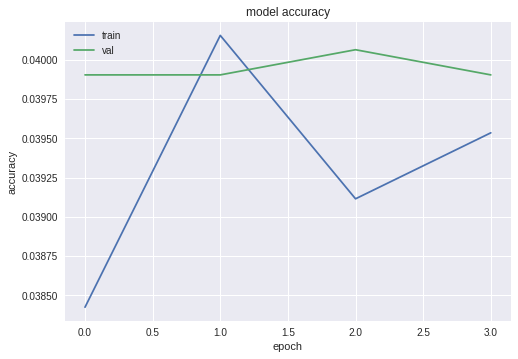

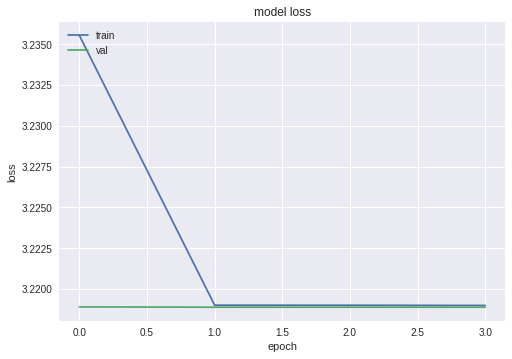

In [21]:
plot_acc_and_loss(history)

Podemos ver que el modelo no se entreno bien. No obtuvo un buen rendimiento sobre el set de validacion (4%) y se empezó a overfittear despues de la epoca 20.

### Probando con ResNet

Probamos utilizando la arquitectura de ResNet

In [0]:
#Settings set
!wget https://www.dropbox.com/s/bc8b71zay6s9rb4/Places25.zip?dl=0
!unzip -q Places25.zip?dl=0

In [0]:
resnet50 = applications.resnet50.ResNet50(weights=None, classes=25)

In [8]:
#Load the images
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'Places25/train/',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
        'Places25/val/',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

Found 100001 images belonging to 25 classes.
Found 12500 images belonging to 25 classes.


In [0]:
checkpoints = ModelCheckpoint(filepath='checkpoints/restnet50_places.hdf5', verbose=1, save_best_only=True)
history = History()
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose=1, mode='auto')

In [0]:
resnet50.compile(loss = 'categorical_crossentropy',
              optimizer= optimizers.Adam(lr=5e-4),
              metrics = ['accuracy'])

In [11]:
resnet50.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // 64,
        epochs=20,
        verbose=1,
        callbacks = [checkpoints, history, earlyStopping],
        validation_data=val_generator,
        validation_steps = val_generator.samples // 64)

resnet50.save('restnet50_places.h5')

Epoch 1/20
1561/1562 [============================>.] - ETA: 1s - loss: 2.0485 - acc: 0.4011

1562/1562 [==============================] - 2822s 2s/step - loss: 2.0480 - acc: 0.4012 - val_loss: 2.1899 - val_acc: 0.3716

Epoch 00001: val_loss improved from inf to 2.18987, saving model to checkpoints/restnet50_places.hdf5
Epoch 2/20
 244/1562 [===>..........................] - ETA: 37:55 - loss: 1.4905 - acc: 0.5444

1561/1562 [============================>.] - ETA: 1s - loss: 1.3833 - acc: 0.5754

1562/1562 [==============================] - 2814s 2s/step - loss: 1.3834 - acc: 0.5754 - val_loss: 1.9785 - val_acc: 0.4639

Epoch 00002: val_loss improved from 2.18987 to 1.97854, saving model to checkpoints/restnet50_places.hdf5
Epoch 3/20
 242/1562 [===>..........................] - ETA: 37:27 - loss: 1.1929 - acc: 0.6307

1561/1562 [============================>.] - ETA: 1s - loss: 1.1428 - acc: 0.6474

1562/1562 [==============================] - 2782s 2s/step - loss: 1.1425 - acc: 0.6474 - val_loss: 1.5963 - val_acc: 0.5345

Epoch 00003: val_loss improved from 1.97854 to 1.59634, saving model to checkpoints/restnet50_places.hdf5
Epoch 4/20
 242/1562 [===>..........................] - ETA: 36:49 - loss: 1.0178 - acc: 0.6807

1561/1562 [============================>.] - ETA: 1s - loss: 1.0078 - acc: 0.6868

1562/1562 [==============================] - 2784s 2s/step - loss: 1.0077 - acc: 0.6869 - val_loss: 1.9119 - val_acc: 0.4503

Epoch 00004: val_loss did not improve from 1.59634
Epoch 5/20
 281/1562 [====>.........................] - ETA: 36:37 - loss: 0.9025 - acc: 0.7154

1561/1562 [============================>.] - ETA: 1s - loss: 0.8887 - acc: 0.7214

1562/1562 [==============================] - 2816s 2s/step - loss: 0.8886 - acc: 0.7214 - val_loss: 1.4169 - val_acc: 0.5818

Epoch 00005: val_loss improved from 1.59634 to 1.41686, saving model to checkpoints/restnet50_places.hdf5
Epoch 6/20
 242/1562 [===>..........................] - ETA: 37:42 - loss: 0.7990 - acc: 0.7466

1561/1562 [============================>.] - ETA: 1s - loss: 0.8083 - acc: 0.7458

1562/1562 [==============================] - 2819s 2s/step - loss: 0.8085 - acc: 0.7457 - val_loss: 0.9785 - val_acc: 0.7014

Epoch 00006: val_loss improved from 1.41686 to 0.97850, saving model to checkpoints/restnet50_places.hdf5
Epoch 7/20
 242/1562 [===>..........................] - ETA: 37:45 - loss: 0.7022 - acc: 0.7750

1561/1562 [============================>.] - ETA: 1s - loss: 0.7098 - acc: 0.7749

1562/1562 [==============================] - 2819s 2s/step - loss: 0.7099 - acc: 0.7749 - val_loss: 1.3200 - val_acc: 0.6131

Epoch 00007: val_loss did not improve from 0.97850
Epoch 8/20
 281/1562 [====>.........................] - ETA: 36:38 - loss: 0.6135 - acc: 0.8006

1561/1562 [============================>.] - ETA: 1s - loss: 0.6333 - acc: 0.7978

1562/1562 [==============================] - 2819s 2s/step - loss: 0.6335 - acc: 0.7978 - val_loss: 1.2995 - val_acc: 0.6256

Epoch 00008: val_loss did not improve from 0.97850
Epoch 9/20
 281/1562 [====>.........................] - ETA: 36:41 - loss: 0.5216 - acc: 0.8313

1561/1562 [============================>.] - ETA: 1s - loss: 0.5403 - acc: 0.8253

1562/1562 [==============================] - 2805s 2s/step - loss: 0.5404 - acc: 0.8253 - val_loss: 0.9208 - val_acc: 0.7194

Epoch 00009: val_loss improved from 0.97850 to 0.92076, saving model to checkpoints/restnet50_places.hdf5
Epoch 00009: early stopping


Podemos observar que nuestro modelo no tuvo una mejora significativa en su función de perdida en el set de validación en las últimas tres épocas, por lo que se deja de entrenar para evitar un overfitting

Subimos el modelo a drive

In [12]:
uploaded = drive.CreateFile({'title': 'restnet50_places'})
uploaded.SetContentFile('restnet50_places.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1JLyEJWwUsaT14kw1ZCfuJahQ2_a94pKz


In [0]:
#Save resnet50 weights
resnet50.save_weights('restnet50_places_weights.h5')
uploaded = drive.CreateFile({'title': 'restnet50_places_weights'})
uploaded.SetContentFile('restnet50_places_weights.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Vamos a graficar el accuracy y val_loss con respecto a las epocas

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


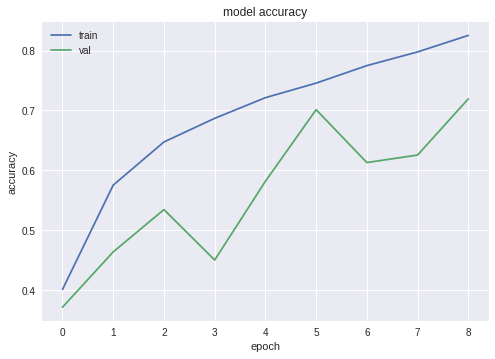

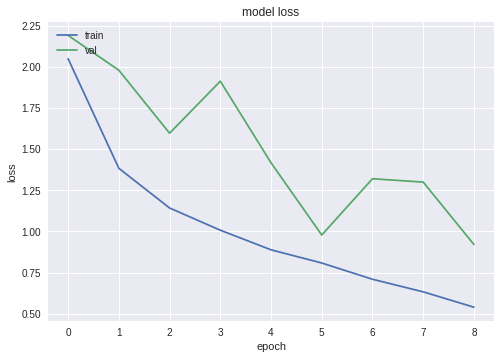

In [14]:
plot_acc_and_loss(history)

Como podemos obvservar en los graficos mostrados arriba, el accuracy siempre fue subiendo en el set de train, sin embargo, en el set de validacion a partir del epoch 5 comenzó a bajar, para luego volver a lo que habia estado para el epoch 8, por lo que se deja de entrenar. 

Con el Loss pasó lo mismo, este siempre bajó en el set de training, sin embargo, del epoch 5 al 6 subió en el set de validación, y volvió a bajar para la época 8.

El hecho de que haya subido y luego vuelto a bajar, nos lleva a pensar que quizás ponerle paciencia 3 al Early Stop puede haber sido muy poco, y que con mas entrenamiento este valor puede haber seguido bajando, por lo que intentaremos seguir entrenando la red con más epocas.

Vamos a cambiar el learning rate a 1e-4 y seguir entrenando para ver si logramos mejorar las métricas obtenidas

In [0]:
#Create new model and load weights
new_resnet50 = applications.resnet50.ResNet50(weights=None, classes=25)
new_resnet50.load_weights('restnet50_places_weights.h5')

In [0]:
#We are going to reduce the learning rate and try fitting again
new_resnet50.compile(loss = 'categorical_crossentropy',
              optimizer= optimizers.Adam(lr=1e-4),
              metrics = ['accuracy'])

In [25]:
new_resnet50.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // 64,
        epochs=20,
        verbose=1,
        callbacks = [checkpoints, history, earlyStopping],
        validation_data=val_generator,
        validation_steps = val_generator.samples // 64)

Epoch 1/20
1561/1562 [============================>.] - ETA: 1s - loss: 0.2437 - acc: 0.9234

1562/1562 [==============================] - 2833s 2s/step - loss: 0.2437 - acc: 0.9234 - val_loss: 0.9122 - val_acc: 0.7582

Epoch 00001: val_loss improved from 0.92076 to 0.91222, saving model to checkpoints/restnet50_places.hdf5
Epoch 2/20
 242/1562 [===>..........................] - ETA: 37:53 - loss: 0.1578 - acc: 0.9510

1561/1562 [============================>.] - ETA: 1s - loss: 0.1635 - acc: 0.9484

1562/1562 [==============================] - 2823s 2s/step - loss: 0.1634 - acc: 0.9484 - val_loss: 0.9623 - val_acc: 0.7583

Epoch 00002: val_loss did not improve from 0.91222
Epoch 3/20
 281/1562 [====>.........................] - ETA: 36:43 - loss: 0.0949 - acc: 0.9709

1561/1562 [============================>.] - ETA: 1s - loss: 0.1005 - acc: 0.9692

1562/1562 [==============================] - 2807s 2s/step - loss: 0.1005 - acc: 0.9692 - val_loss: 1.0928 - val_acc: 0.7510

Epoch 00003: val_loss did not improve from 0.91222
Epoch 4/20
 281/1562 [====>.........................] - ETA: 36:17 - loss: 0.0591 - acc: 0.9832

1561/1562 [============================>.] - ETA: 1s - loss: 0.0644 - acc: 0.9806

1562/1562 [==============================] - 2805s 2s/step - loss: 0.0644 - acc: 0.9806 - val_loss: 1.2615 - val_acc: 0.7514

Epoch 00004: val_loss did not improve from 0.91222
Epoch 00004: early stopping


Podemos observar que la función de pérdida en el set de validación no mejoró con más entrenamiento, por lo que nos quedaremos con el modelo anterior, de manera de evitar overfiteo.


In [0]:
#Save newResnet50 model and weights
new_resnet50.save('restnet50_places_02.h5')
new_resnet50.save_weights('restnet50_places_weights_02.h5')

In [0]:
ls

In [0]:
#Upload model
uploaded = drive.CreateFile({'title': 'restnet50_places_02'})
uploaded.SetContentFile('restnet50_places_02.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
#Upload weights
uploaded = drive.CreateFile({'title': 'restnet50_places_weights_02'})
uploaded.SetContentFile('restnet50_places_weights_02.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


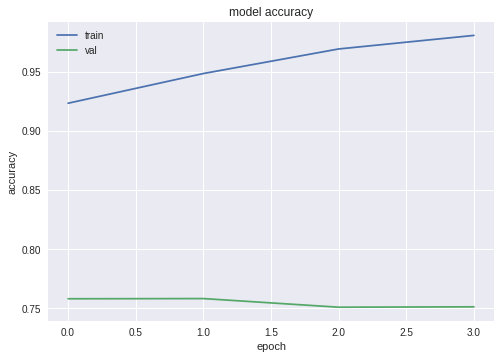

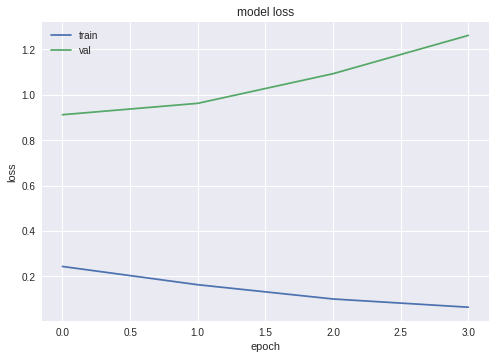

In [30]:
plot_acc_and_loss(history)

Podemos observar que al intentar entrenar más épocas, el modelo comenzó a overfitearse, por lo que decidimos quedarnos con el original. Si miramos la gráfica de la accuracy, la accuracy sobre el test comienza a subir mientras que la accuracy sobre el val comienza a bajar

## Actividad 12

Vemos el contenido de Drive de manera de encontrar el ID del modelo

In [0]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [0]:
# Initialize GoogleDriveFile instance with file id and download model to local storage
file = drive.CreateFile({'id': '1JLyEJWwUsaT14kw1ZCfuJahQ2_a94pKz'})
file.GetContentFile('model.h5') # Download file as 'model.h5'

In [0]:
ls

Cargamos el modelo a una instancia de Keras

In [0]:
model = load_model('model.h5')

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Importamos la funcion para medir el accuracy score, generar una matriz de confusion de sklearn, y tambien matplotlib para graficarla

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import itertools

Procedemos a cargar el set de test

In [18]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        'Places25/test',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        shuffle = False)

Found 12500 images belonging to 25 classes.


In [0]:
Y_predicted = model.predict_generator(test_generator)

In [0]:
def get_classes(pred):
  output = []
  for prediction in pred:
    output.append(prediction.argmax())
  return np.array(output)

In [0]:
y_true = test_generator.classes
y_pred = get_classes(Y_predicted)

In [29]:
test_accuracy = accuracy_score(y_true, y_pred)
test_accuracy

0.7172

Podemos notar que obtuvimos un 71% de accuracy sobre el set de test.

Mirando el fit_generator, vemos que el modelo tuvo un 83% de accuracy sobre el set de entrenamiento y 72% sobre el set de validación.

Como el accuracy del set de validación es casi igual al set de test, podemos notar que el modelo tiene muy poca varianza, es decir, no se overfitteo casi nada. Esta accuracy es relativamente bueno comparando con los benchmark sobre problemas similares, pero considerando el 'human-level accuracy' que se aproxima al 99.5%, se puede concluir que este modelo no pudo cumplir la tarea de manera realmente eficiente porque le falta casi 30% de accuracy para poder acercase al ojo humano. 

Para una siguiente iteración haría sentido probar con una red un poco más profunda, reducir un poco la regularización y los batch normalization para que el modelo tenga más capacidad para aprender todavía. 

Creamos la matriz de confusión

In [0]:
## code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
cnf_matrix = confusion_matrix(y_true, y_pred)

Podemos notar que las clases estan estratificadas, por lo que la matriz de confusión esta tambien estratificada.

Confusion matrix, without normalization


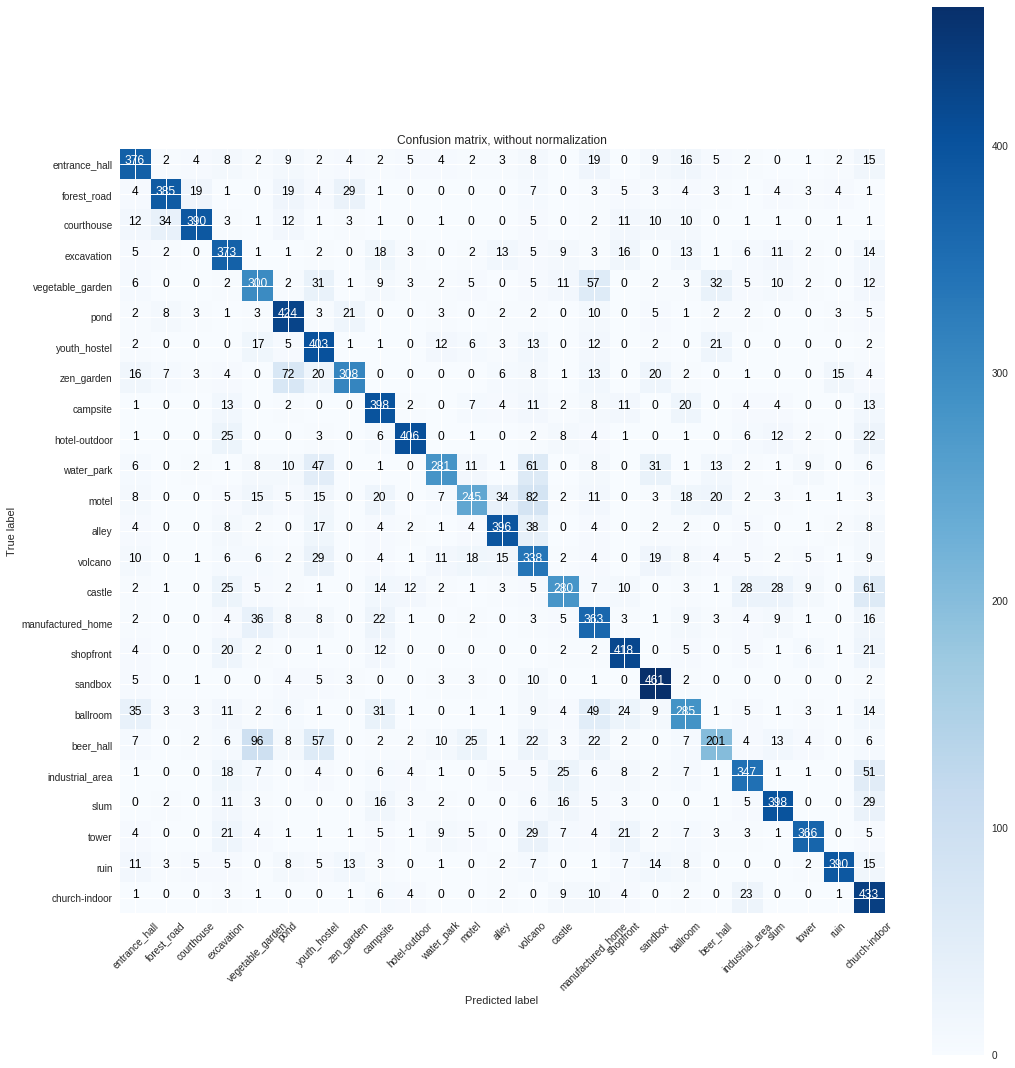

In [41]:
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes = classes,
                      title='Confusion matrix, without normalization')

In [8]:
import os
classes = os.listdir('Places25/test/')
#Revisamos la estratificación de los datos
for cl in classes:
  print('La clase {} tiene {} datos de test'.format(cl, len(os.listdir('Places25/test/'+cl))))

La clase entrance_hall tiene 500 datos de test
La clase forest_road tiene 500 datos de test
La clase courthouse tiene 500 datos de test
La clase excavation tiene 500 datos de test
La clase vegetable_garden tiene 500 datos de test
La clase pond tiene 500 datos de test
La clase youth_hostel tiene 500 datos de test
La clase zen_garden tiene 500 datos de test
La clase campsite tiene 500 datos de test
La clase hotel-outdoor tiene 500 datos de test
La clase water_park tiene 500 datos de test
La clase motel tiene 500 datos de test
La clase alley tiene 500 datos de test
La clase volcano tiene 500 datos de test
La clase castle tiene 500 datos de test
La clase manufactured_home tiene 500 datos de test
La clase shopfront tiene 500 datos de test
La clase sandbox tiene 500 datos de test
La clase ballroom tiene 500 datos de test
La clase beer_hall tiene 500 datos de test
La clase industrial_area tiene 500 datos de test
La clase slum tiene 500 datos de test
La clase tower tiene 500 datos de test
La c

Mirando la matriz de confusión, concluimos que la clase 'sandbox' fue la clase mejor predica con un 92% de accuracy (461 / 500). Ésta métrica es bastante buena considerando que el set de test está bien distribuido y cada clase tiene 500 imágenes para testear. 

Notamos que el modelo confundio a 'sandbox' con la clase 'volcano' un 2% de las veces, siendo la clase de mayor distracción.

Mostraremos fotos de ambos sets

In [0]:
import matplotlib.image as mpimg

def show_img(path):
  img=mpimg.imread(path)
  imgplot = plt.imshow(img)
  plt.show()

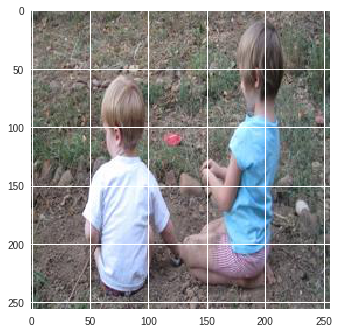

In [61]:
show_img('Places25/train/sandbox/00000001.jpg')

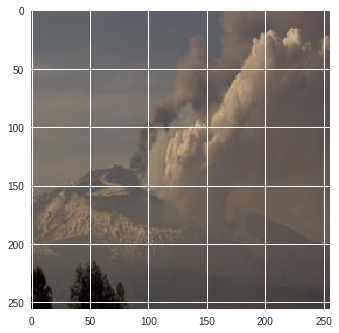

In [62]:
show_img('Places25/train/volcano/00000001.jpg')

Si miramos ambas fotos, entendemos la confusión del modelo. Ambas imágenes tienen colores y texturas similares, notamos que los sandbox y volcanes tienen arena o tierra, lo que para ciertos casos podría confundir al modelo.

Por el otro lado, el modelo tuvo la peor accuracy sobre la clase 'beer_hall' donde obtuvo 40% (201 / 500). El modelo confundió un 19% de las veces a la clase 'beer_hall' con la clase 'vegetable_garden', siendo la clase de mayor confusión. Mostramos fotos de ambos sets

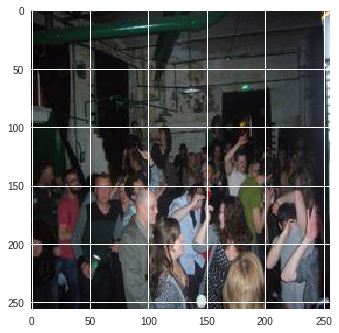

In [72]:
show_img('Places25/train/beer_hall/00000007.jpg')

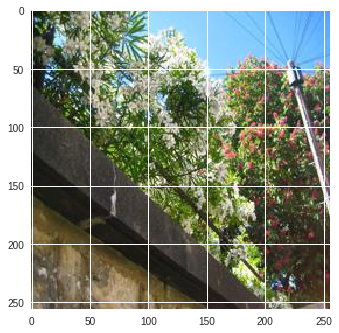

In [73]:
show_img('Places25/train/vegetable_garden/00000004.jpg')

La diferencia no es tan clara como en el ejemplo de antes, porque el modelo para este caso solo predijo con un 40% por lo que fácilmente podría equivocarse. Aun así, notamos que hay similitudes en las fotos en factores como: muchos cambios de colores drásticos, muchos conjuntos de objetos de colores iguales (flores, personas) etc... 